In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


✅ Loaded 169845 samples with 7 classes.
Label mapping: {'anger': np.int64(0), 'fear': np.int64(1), 'joy': np.int64(2), 'love': np.int64(3), 'neutral': np.int64(4), 'sadness': np.int64(5), 'surprise': np.int64(6)}


Map:   0%|          | 0/135876 [00:00<?, ? examples/s]

Map:   0%|          | 0/33969 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3201234123.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.744600,0.709999,0.753540,0.757273,0.753540,0.754190
2,0.526400,0.613797,0.791575,0.798561,0.791575,0.792108
3,0.375600,0.645024,0.804822,0.805885,0.804822,0.804904



📊 Validation Metrics:
eval_loss: 0.6138
eval_accuracy: 0.7916
eval_precision: 0.7986
eval_recall: 0.7916
eval_f1: 0.7921
eval_runtime: 120.6288
eval_samples_per_second: 281.5990
eval_steps_per_second: 17.6080
epoch: 3.0000

Classification Report:

              precision    recall  f1-score   support

       anger     0.7513    0.7642    0.7577      4000
        fear     0.8402    0.8917    0.8652      4988
         joy     0.6851    0.8548    0.7606      4980
        love     0.7700    0.7489    0.7593      5826
     neutral     0.9085    0.7484    0.8207      5004
     sadness     0.8025    0.7854    0.7939      4171
    surprise     0.8277    0.7486    0.7862      5000

    accuracy                         0.7916     33969
   macro avg     0.7979    0.7917    0.7919     33969
weighted avg     0.7986    0.7916    0.7921     33969



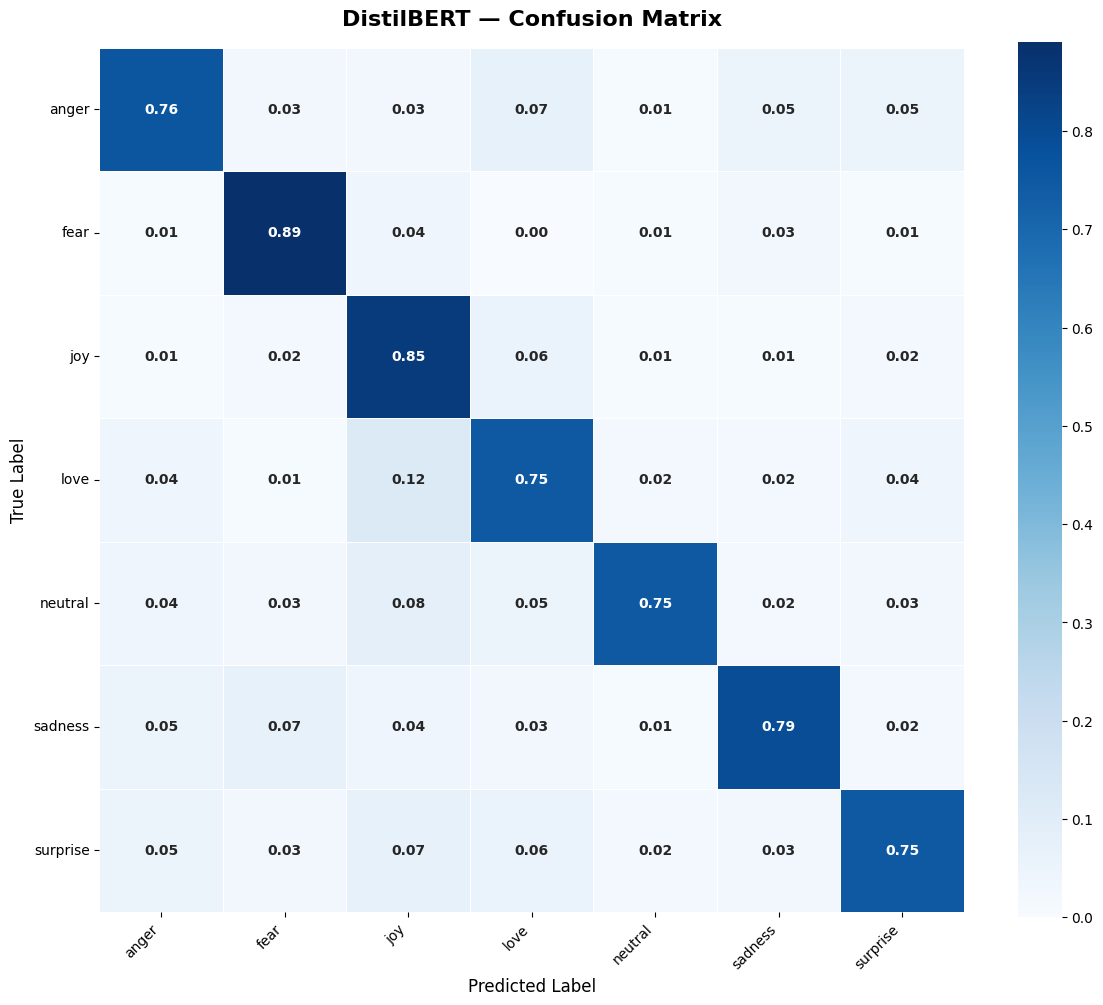


✅ DistilBERT model, tokenizer, and label encoder saved to /content/drive/MyDrive/DriveAce


In [4]:
# ================================================================
# 🧠 MindScape — DistilBERT-base-uncased
# ================================================================

import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ---------------------------
# Config / paths
# ---------------------------
SAVE_DIR = "/content/drive/MyDrive/DriveAce"  # change if needed
os.makedirs(SAVE_DIR, exist_ok=True)
DATA_CSV = "/content/balanced_emotion_dataset.csv"      # change to your path
MAX_LEN = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
LR = 3e-5
SEED = 42

# ---------------------------
# Reproducibility
# ---------------------------
def set_seed(seed=SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

# ---------------------------
# Load & prepare dataset
# ---------------------------
df = pd.read_csv(DATA_CSV)[['text', 'emotion']].dropna()
print(f"✅ Loaded {len(df)} samples with {df['emotion'].nunique()} classes.")

le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])
num_labels = len(le.classes_)
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# ---------------------------
# Tokenizer & tokenization fn
# ---------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# Keep only torch columns the trainer expects
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ---------------------------
# Model
# ---------------------------
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# ---------------------------
# Training arguments
# ---------------------------
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_distilbert",
    logging_steps=100,
    report_to="none"
)


# ---------------------------
# Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ---------------------------
# Train
# ---------------------------
trainer.train()

# ---------------------------
# Evaluate & report
# ---------------------------
metrics = trainer.evaluate()
print("\n📊 Validation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

# ---------------------------
# Confusion matrix (normalized by true class)
# ---------------------------
def plot_confusion_matrix(y_true, y_pred, labels, model_name="DistilBERT"):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_display = np.round(cm, 2)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='white',
        square=True,
        annot_kws={"size": 10, "weight": "bold"}
    )
    plt.title(f"{model_name} — Confusion Matrix", fontsize=16, fontweight='bold', pad=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, le.classes_, model_name="DistilBERT")

# ---------------------------
# Save model, tokenizer, and label encoder
# ---------------------------
model.save_pretrained(f"{SAVE_DIR}/DistilBERT_MindScape")
tokenizer.save_pretrained(f"{SAVE_DIR}/DistilBERT_MindScape")
with open(f"{SAVE_DIR}/distilbert_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"\n✅ DistilBERT model, tokenizer, and label encoder saved to {SAVE_DIR}")


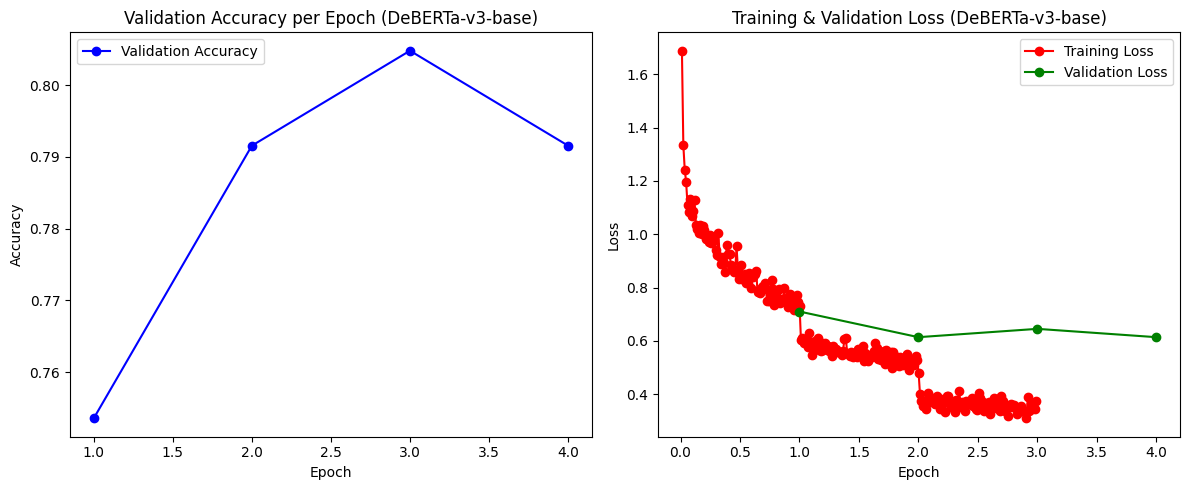

✅ Graphs generated successfully for checkpoint at /content/drive/MyDrive/DriveAce/DistilBERT_MindScape


In [10]:
# ================================================================
# 📊 MindScape — Training & Validation Graphs (DeBERTa-v3-base)
# ================================================================

import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# ---------------------------
# STEP 1 — Load Checkpoint
# ---------------------------
MODEL_PATH = "/content/drive/MyDrive/DriveAce/DistilBERT_MindScape"

# Load model & tokenizer (optional, mainly for trainer context)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# ---------------------------
# STEP 2 — Access Trainer Logs (from previous session)
# ---------------------------
# If your trainer variable still exists from training:
logs = trainer.state.log_history

# Otherwise, if you restarted runtime, reloading logs from the `results_deberta_v3` directory:
# logs = torch.load("./results_deberta_v3/trainer_state.json")["log_history"]

train_loss, eval_loss, eval_acc = [], [], []
epochs = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_acc.append(log["eval_accuracy"])

# ---------------------------
# STEP 3 — Plot Graphs
# ---------------------------
plt.figure(figsize=(12, 5))

# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, marker='o', label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy per Epoch (DeBERTa-v3-base)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='red')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, marker='o', label='Validation Loss', color='green')
plt.title("Training & Validation Loss (DeBERTa-v3-base)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

print(f"✅ Graphs generated successfully for checkpoint at {MODEL_PATH}")


In [11]:

# ================================================================
# 🔮 MindScape — Real-Time Emotion Prediction (DeBERTa-v3-base)
# ================================================================

import torch
import pickle
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# ---------------------------
# STEP 1 — Load Saved Model + Tokenizer + LabelEncoder
# ---------------------------
SAVE_DIR = "/content/drive/MyDrive/DriveAce/DistilBERT_MindScape"

tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
with open("/content/drive/MyDrive/DriveAce/distilbert_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ---------------------------
# STEP 2 — Single Prediction Function
# ---------------------------
def predict_emotion(text: str):
    """Predict emotion for a single text string."""
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    emotion = le.inverse_transform([pred_idx])[0]
    confidence = probs[0][pred_idx].item()

    print(f"\n🗣️ Input: {text}")
    print(f"💫 Predicted Emotion: **{emotion}**  (Confidence: {confidence:.3f})")

    return emotion, confidence

# ---------------------------
# STEP 3 — Batch Prediction Function
# ---------------------------
def predict_emotions(text_list):
    """Predict emotions for a list of texts and return a DataFrame."""
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).cpu().numpy()

    emotions = le.inverse_transform(pred_idx)
    confidences = probs.cpu().numpy().max(axis=1)
    df = pd.DataFrame({
        "Text": text_list,
        "Predicted Emotion": emotions,
        "Confidence": np.round(confidences, 3)
    })
    return df

# ---------------------------
# ✅ Example Usage
# ---------------------------

# Single example
predict_emotion("I’m feeling hopeful and motivated today!")

# Batch examples
texts = [
    "That’s such a touching and beautiful story.",
    "I’m really frustrated and angry right now.",
    "I feel lonely and empty lately.",
    "This made my day so much better!",
]
results = predict_emotions(texts)
print("\n📋 Batch Predictions:\n")
display(results)



🗣️ Input: I’m feeling hopeful and motivated today!
💫 Predicted Emotion: **fear**  (Confidence: 0.992)

📋 Batch Predictions:



,Text,Predicted Emotion,Confidence
0,That’s such a touching and beautiful story.,joy,0.457
1,I’m really frustrated and angry right now.,fear,0.995
2,I feel lonely and empty lately.,fear,0.998
3,This made my day so much better!,neutral,0.997
